(chap_histograms)=
(chap_measurements)=
# Measurements & histograms

:::{admonition} Chapter outline 
:class: tip

* **Measurements** can be made in images by calculating statistics from the pixel values
* **Histograms** show the distribution of pixel values in an image, and are extremely useful to compare images & diagnose problems
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

{ref}`chap_pixels` demonstrated how looks can be deceiving: the visual appearance of an image isn't enough to determine what data it contains.

Because scientific image analysis depends upon having the right pixel values in the first place, this leads to the important admonition:

:::{admonition} Keep your original pixel values safe!
:class: danger

The pixel values in your original image are your raw data: it's essential to protect these from unwanted changes.
:::

This is really important because there are lots of ways to accidentally compromise the raw data of an image -- such as by using the wrong software to adjust the brightness and contrast, or saving the files [in the wrong format](chap_files).
This can cause the results of analysis to be wrong.

What makes this especially tricky is that trustworthy and untrustworthy images can *look* identical. 
Therefore, we need a way to see beyond LUTs to compare the content of images easily and efficiently.

## Comparing histograms & statistics

In principle, if we want to compare two images we could check that every corresponding pixel value is identical in both images.
We will use this approach later, but isn't always necessary.

There are two other things we can do, which are often much faster and easier:

1. Calculate some **summary statistics** from the pixel values, such as the average (mean) pixel value, standard deviation, minimum and maximum values.
2. Check out the image **histogram**. This graphically depicts the distribution of pixel values in the image.

Putting these into action, we can recreate {numref}`fig-images_look_same` but this time add
1. the LUT (shown as a colored bar below the image)
2. a histogram
3. summary statistics

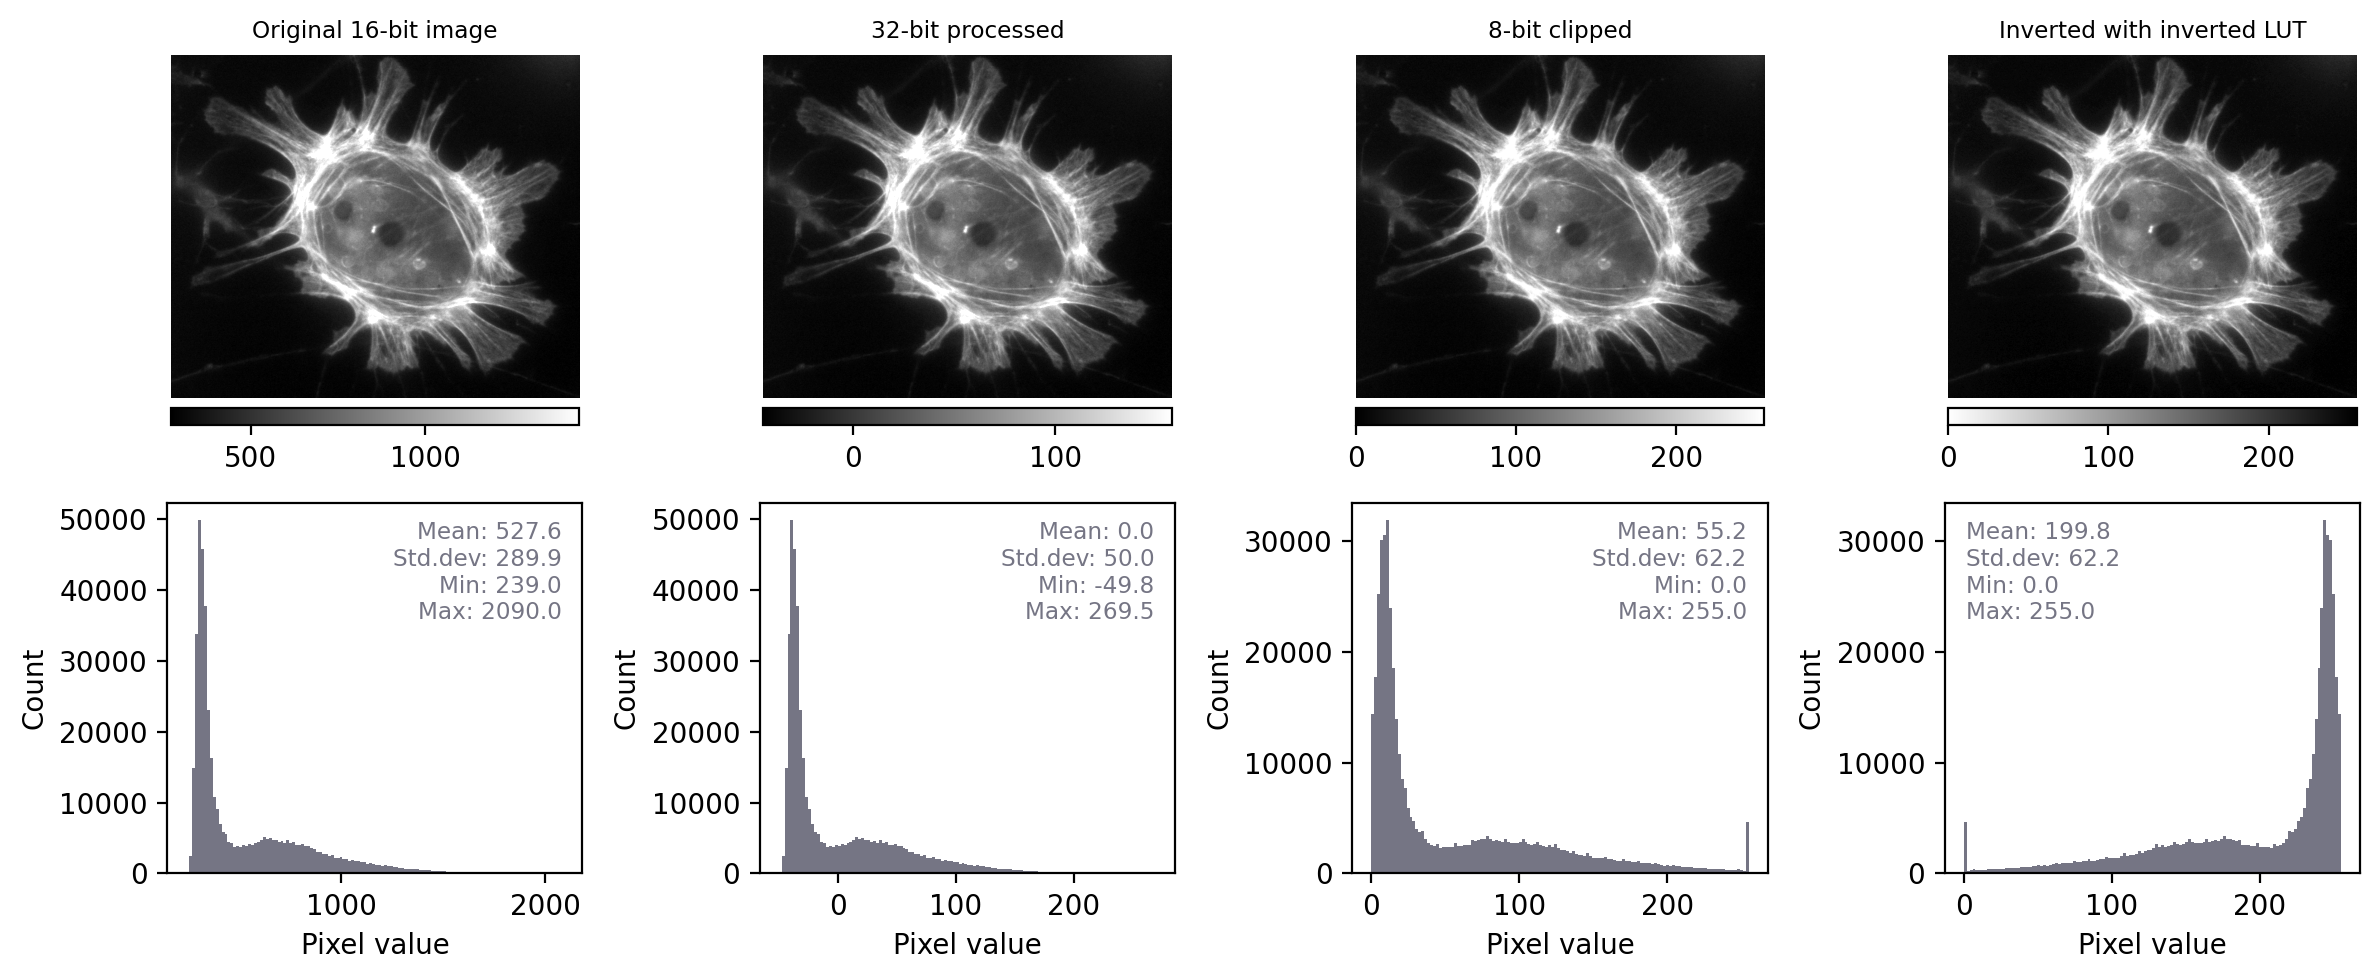

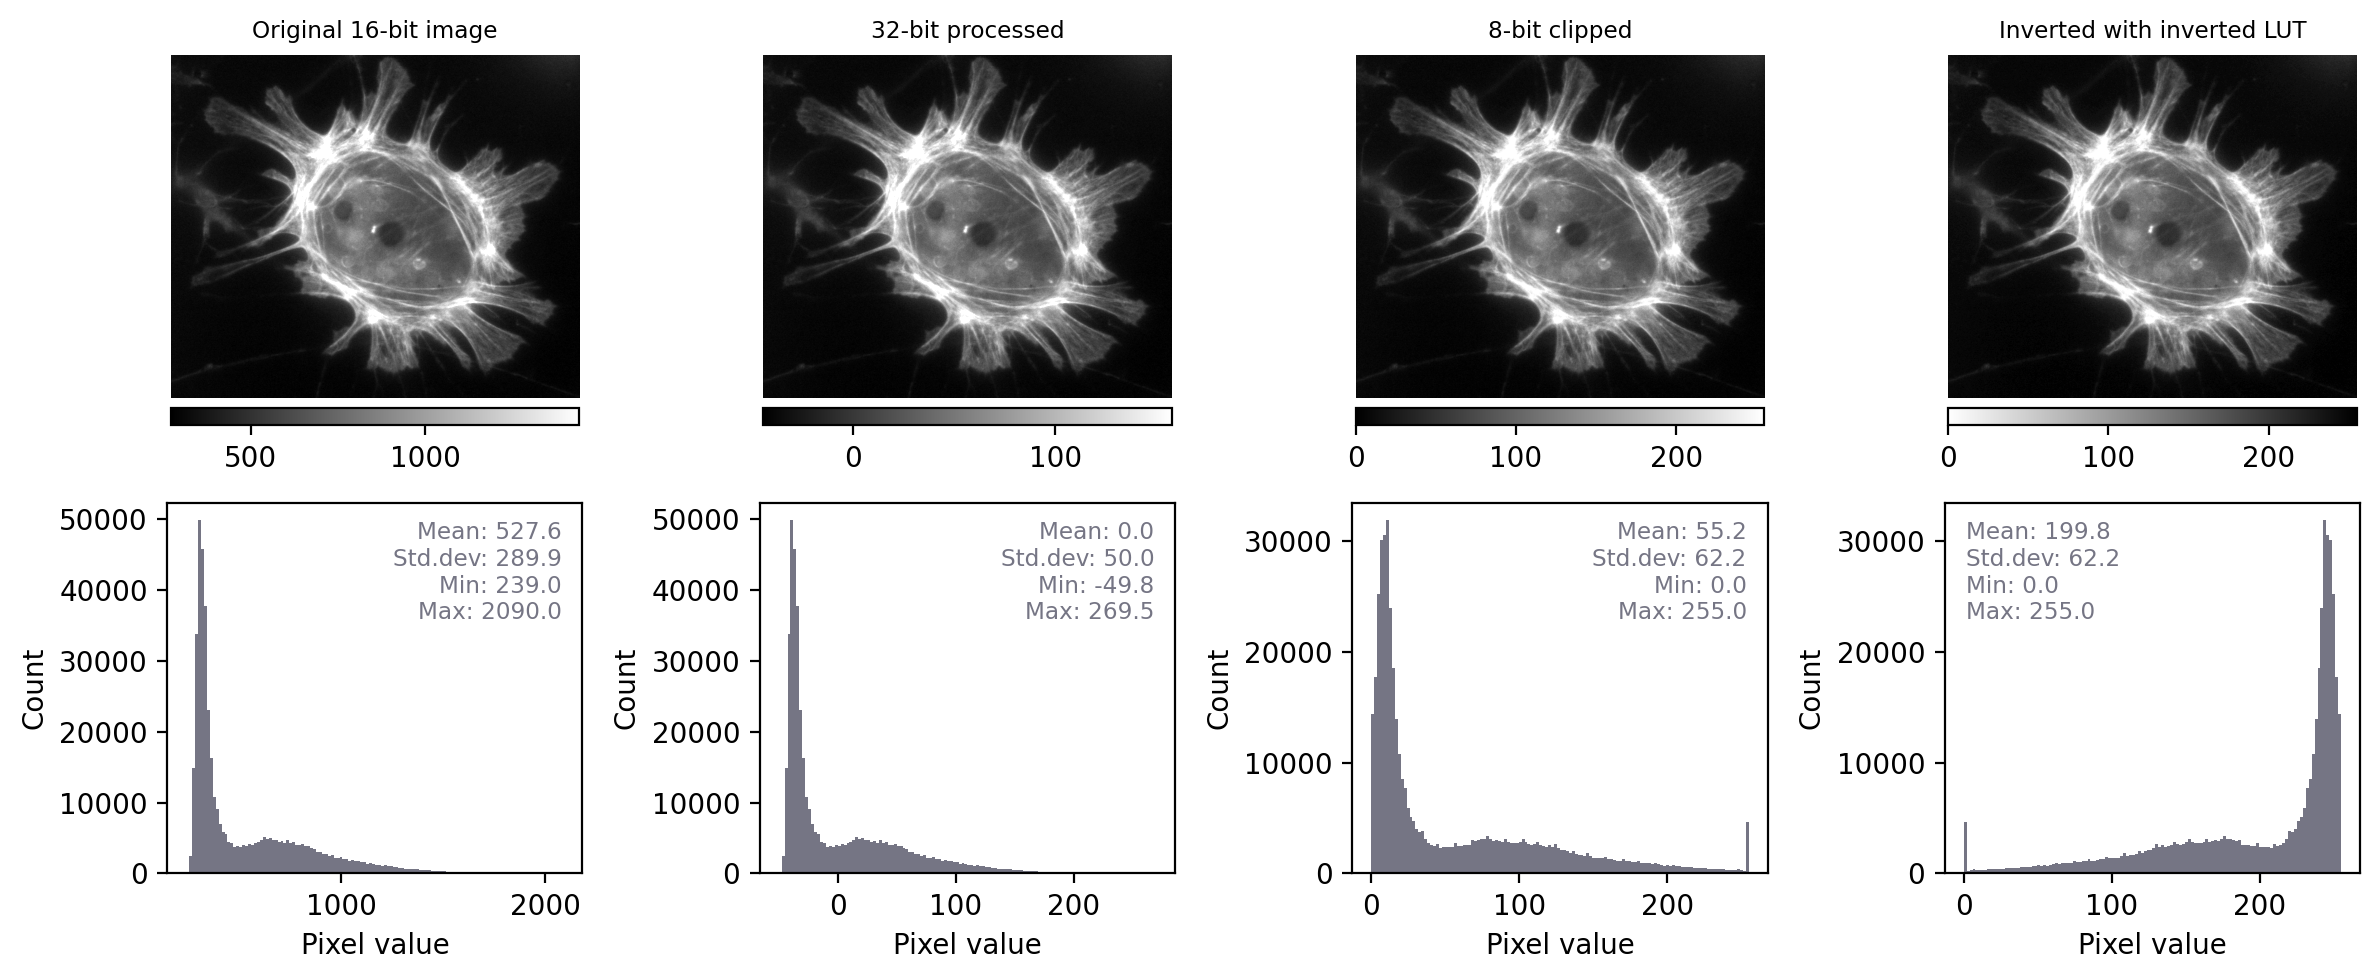

In [2]:
# Create 4 images with different values that look the same

im = load_image('sunny_cell.tif')
assert im.dtype == np.uint16

fig = create_figure(figsize=(12, 5))
colorbar_params = dict(shrink=0.9, orientation='horizontal')

# Original image, with 1% clipped for display
vmin = np.percentile(im, 1)
vmax = np.percentile(im, 99)
show_image(im, cmap='gray', title='Original 16-bit image', vmin=vmin, vmax=vmax, pos=241)
add_colorbar(**colorbar_params)

# 32-bit, rescaled
im2 = (im.astype(np.float32) - im.mean()) / im.std() * 50
vmin2 = np.percentile(im2, 1)
vmax2 = np.percentile(im2, 99)
show_image(im2, cmap='gray', title='32-bit processed', vmin=vmin2, vmax=vmax2, pos=242)
add_colorbar(**colorbar_params)

# 8-bit, clipped
im3 = im.astype(np.float32)
im3 = (im3 - vmin) / (vmax - vmin) * 255
im3 = np.clip(im3, 0, 255)
im3 = im3.astype(np.uint8)
show_image(im3, cmap='gray', title='8-bit clipped', vmin=0, vmax=255, pos=243)
add_colorbar(**colorbar_params)

# 8-bit, clipped, then inverted with inverted LUT
im4 = 255 - im3
show_image(im4, cmap='gray_r', title='Inverted with inverted LUT', vmin=0, vmax=255, pos=244)
add_colorbar(**colorbar_params)

# Show corresponding histograms
bins = 128
show_histogram(im, pos=245, stats='right', bins=bins)
show_histogram(im2, pos=246, stats='right', bins=bins)
show_histogram(im3, pos=247, stats='right', bins=bins)
show_histogram(im4, pos=248, stats='left', bins=bins)

plt.tight_layout()
glue_fig('fig_images_look_same_histograms', fig)

```{glue:figure} fig_images_look_same_histograms
:align: center
:name: fig-images_look_same_histograms
Recreation of {numref}`fig-images_look_same` showing images that *look* the same, but contain *different* pixels values -- this time with measurements and histograms included.
```

With the additional information at our disposal, we can immediately see that the images really **do** contain different underlying values -- and therefore potentially quite different information -- despite their initial similar appearance.
We can also see that the LUTs are different; they show the same colors (shades of gray), but in each case these map to different values.

By contrast, when we apply the same steps to {numref}`fig-images_look_different` we see that the histograms and statistics are identical -- only the LUT has been changed in each case.
This suggests that any analysis we perform on each of these images should give the same results, since the pixel values remain intact.

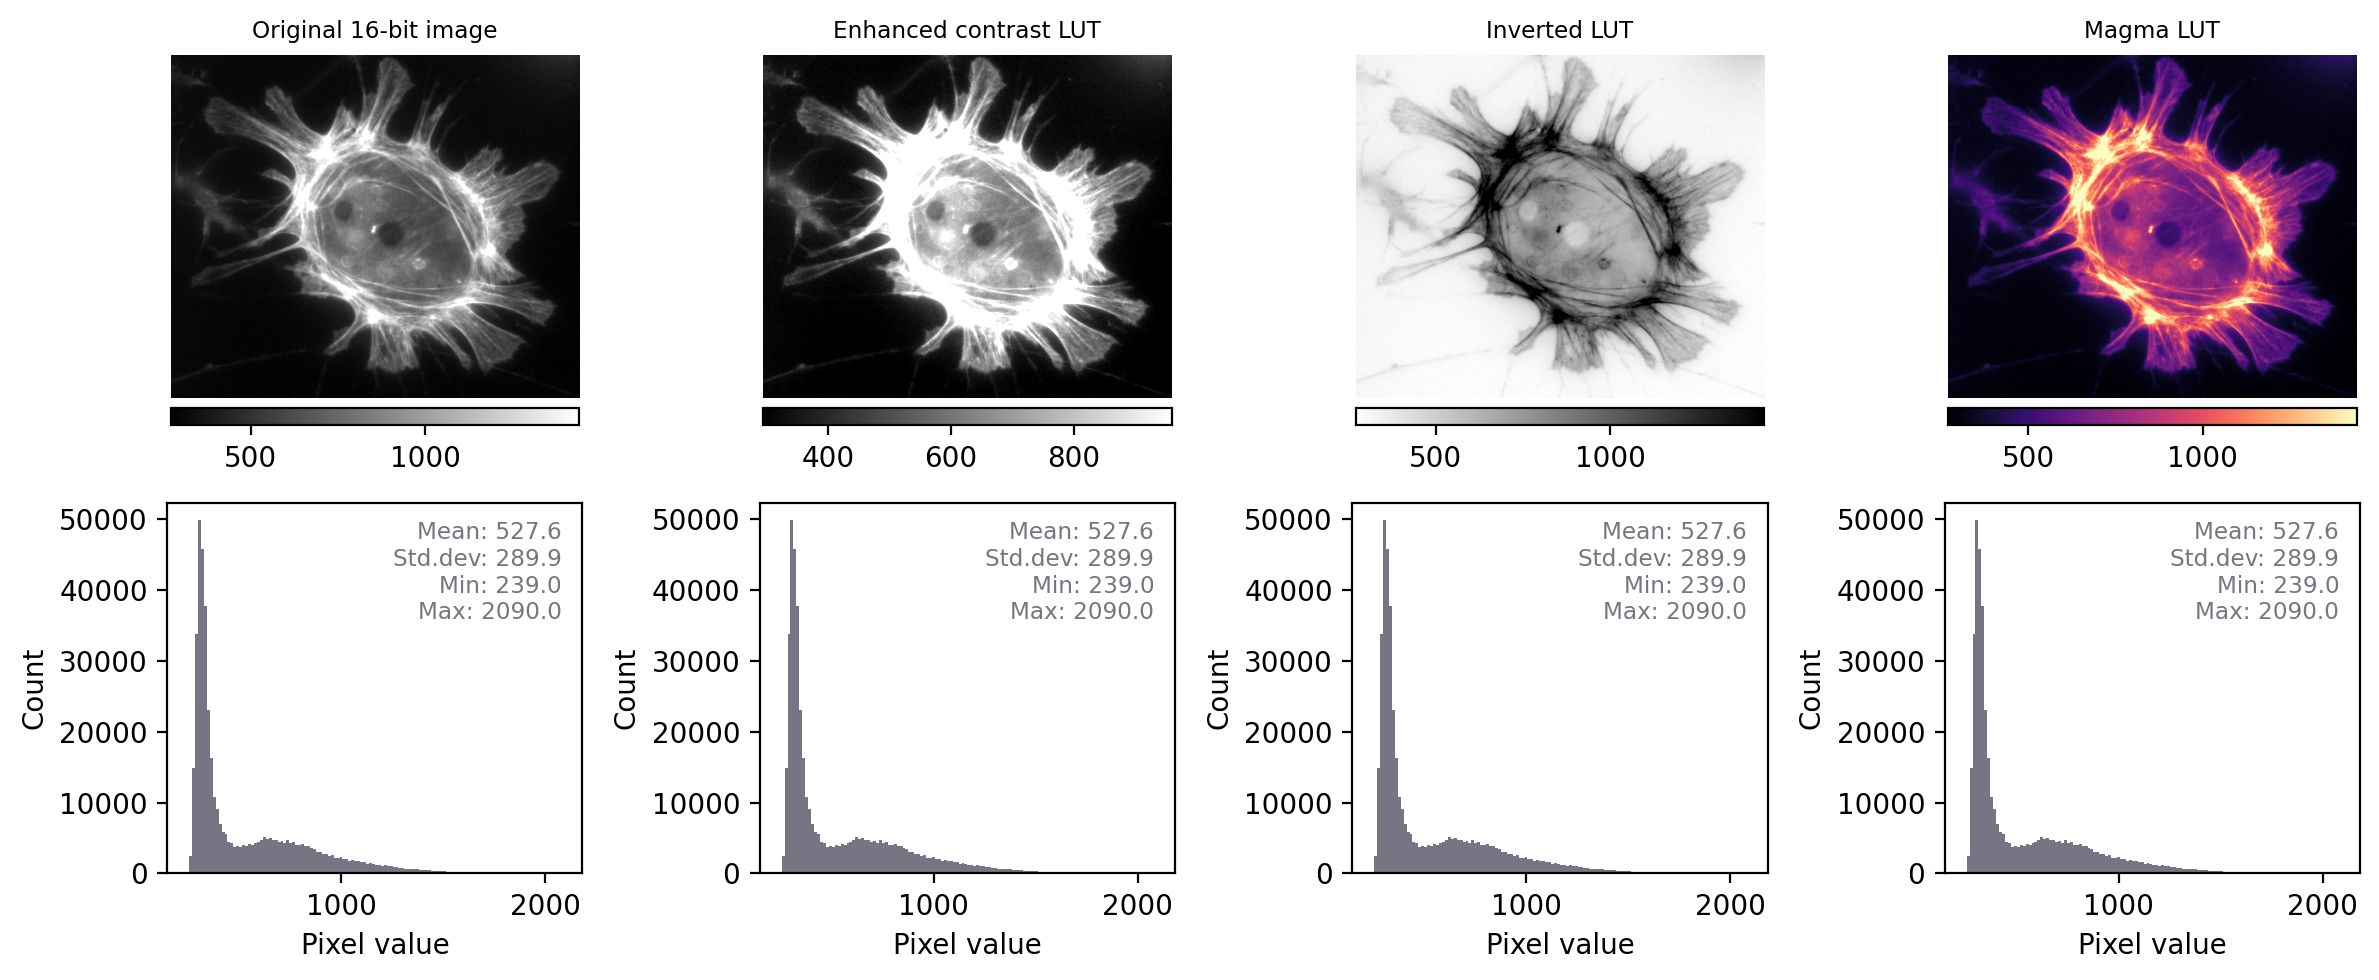

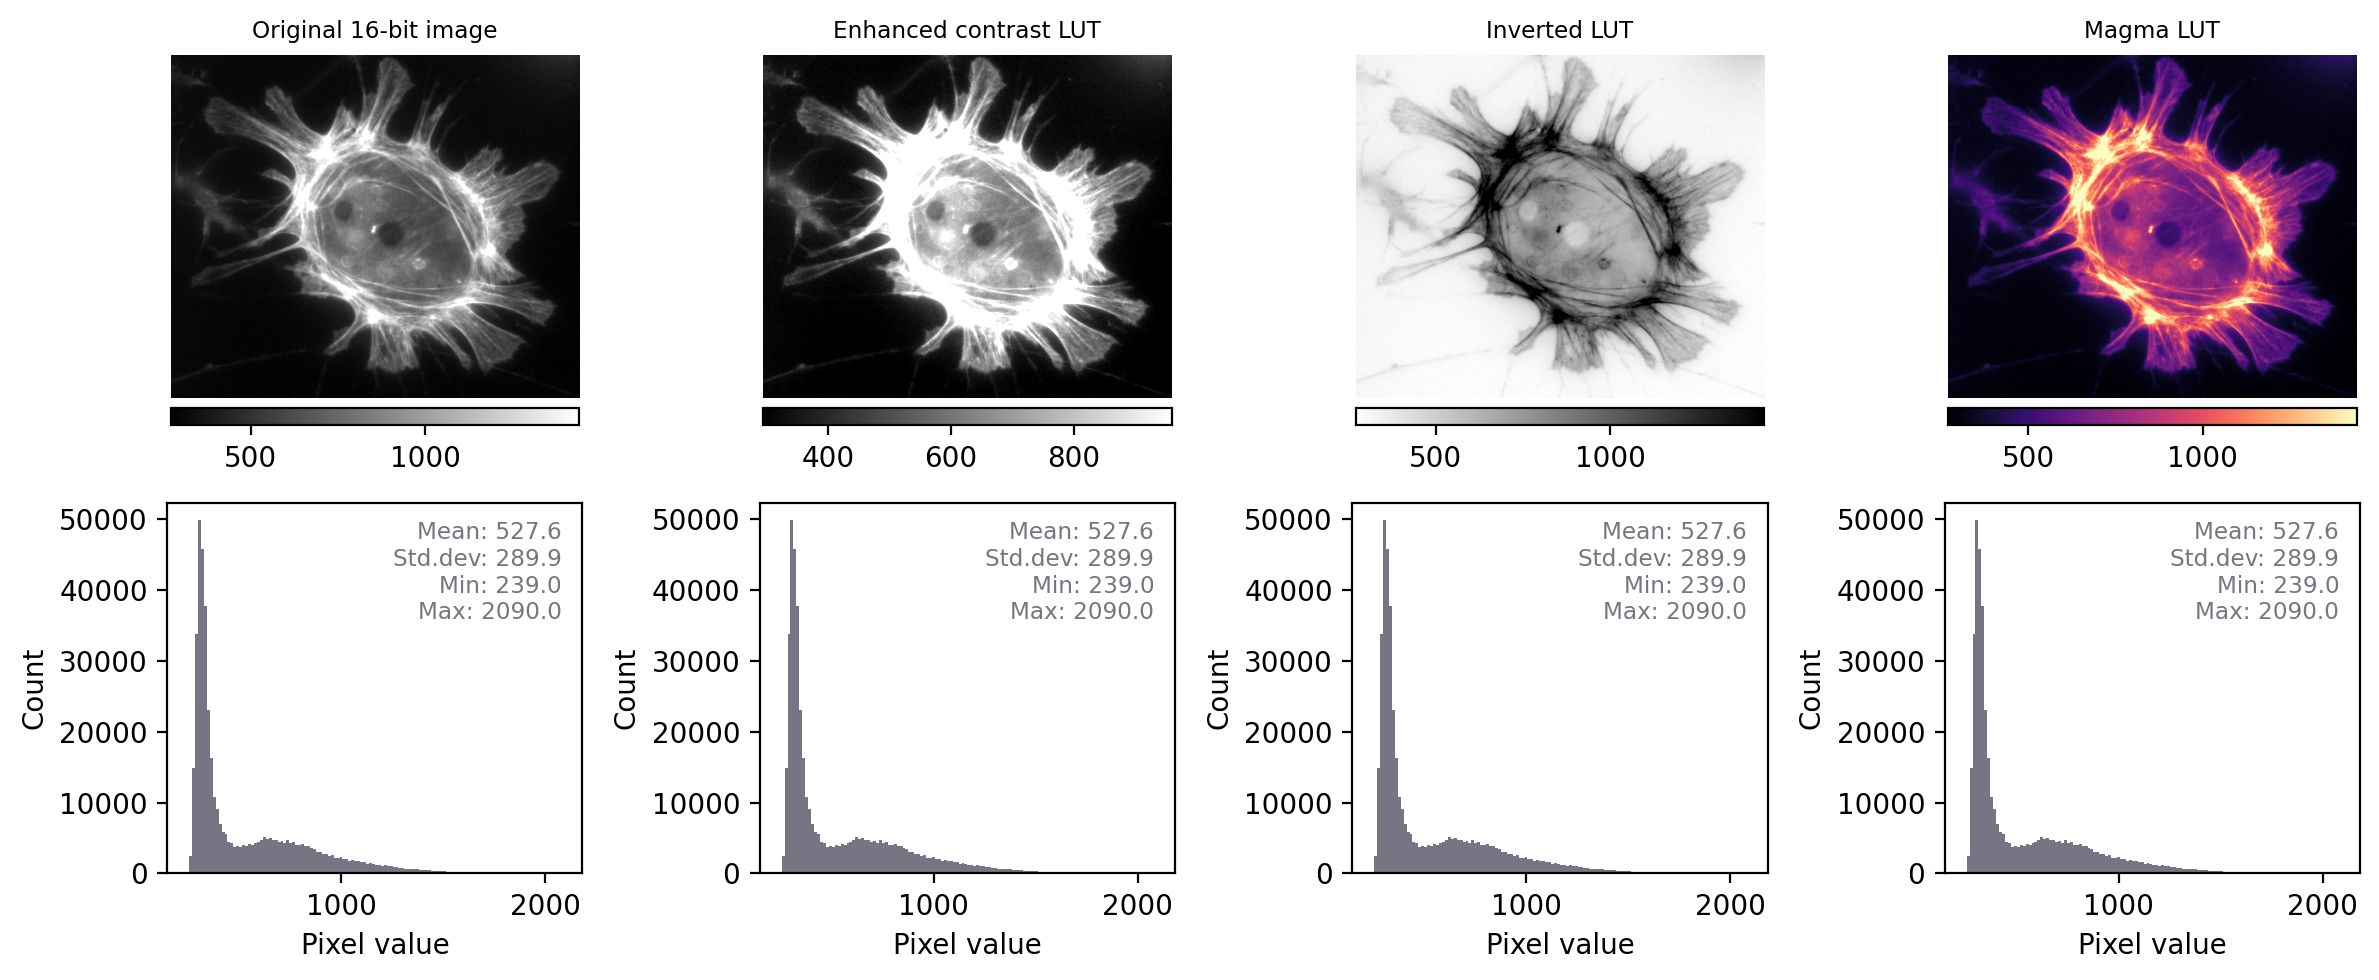

In [3]:
# Display the same image in 4 different ways by changing the LUT/colormap

im = load_image('sunny_cell.tif')
assert im.dtype == np.uint16

# Create 5 images with the same values that look different
fig = create_figure(figsize=(12, 5))
cbar_params = dict(shrink=0.9, orientation='horizontal')

# Original image, with 1% clipped for display
vmin = np.percentile(im, 1)
vmax = np.percentile(im, 99)
show_image(im, cmap='gray', title='Original 16-bit image', vmin=vmin, vmax=vmax, pos=241)
add_colorbar(**colorbar_params)

# Original image, with 10% clipped for display
vmin2 = np.percentile(im, 10)
vmax2 = np.percentile(im, 90)
show_image(im, cmap='gray', title='Enhanced contrast LUT', vmin=vmin2, vmax=vmax2, pos=242)
add_colorbar(**colorbar_params)

# Invert the LUT (in matplotlib, just add '_r' at the end)
show_image(im, cmap='gray_r', title='Inverted LUT', vmin=vmin, vmax=vmax, pos=243)
add_colorbar(**colorbar_params)

# Use an alternative LUT
show_image(im, cmap='magma', title='Magma LUT', vmin=vmin, vmax=vmax, pos=244)
add_colorbar(**colorbar_params)

# Show corresponding histograms
bins = 128
show_histogram(im, pos=245, stats='right', bins=bins)
show_histogram(im, pos=246, stats='right', bins=bins)
show_histogram(im, pos=247, stats='right', bins=bins)
show_histogram(im, pos=248, stats='right', bins=bins)

plt.tight_layout()
glue_fig('fig_images_look_different_histograms', fig)

```{glue:figure} fig_images_look_different_histograms
:align: center
:name: fig-images_look_different_histograms
Recreation of {numref}`fig-images_look_different` showing images that *look* different, but contain *the same* pixel values -- this time with measurements and histograms included.
```

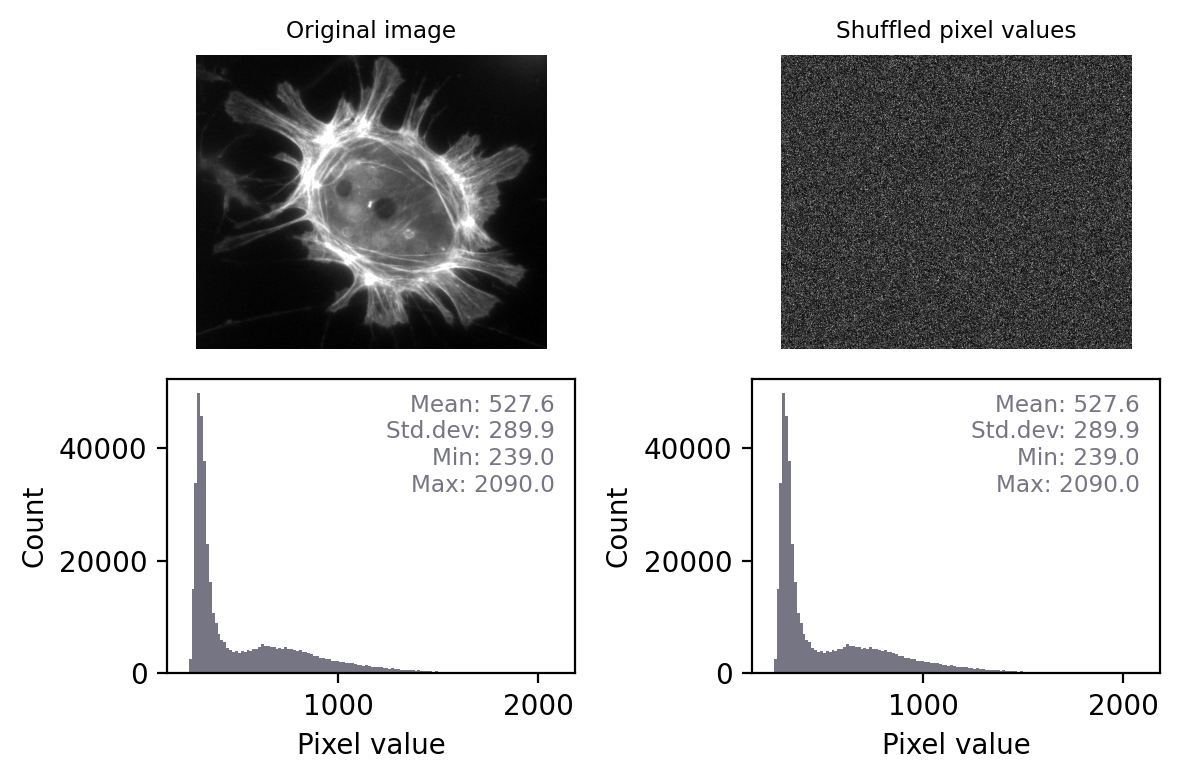

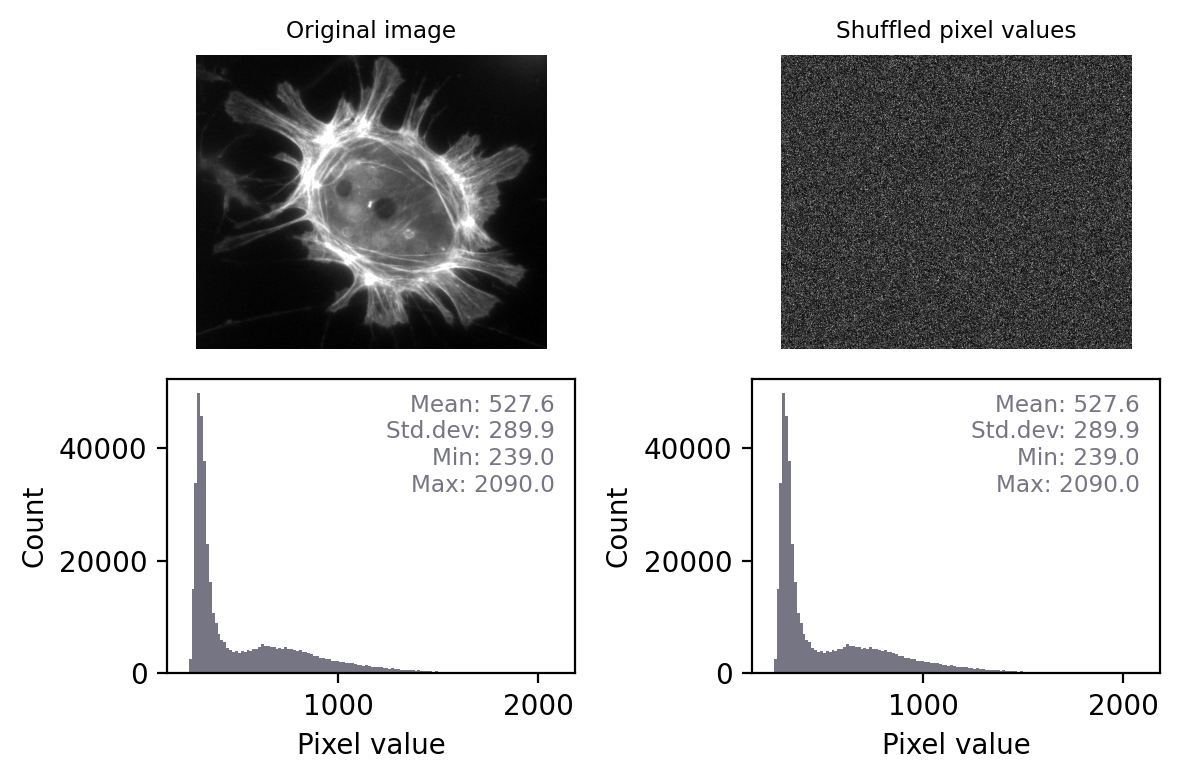

In [4]:
im = load_image('sunny_cell.tif')

# Randomly shuffle the pixel values
rng = np.random.default_rng(100)
im_shuffled = im.flatten()
rng.shuffle(im_shuffled)
im_shuffled = im_shuffled.reshape(im.shape)

bins = 128
fig = create_figure(figsize=(6, 4))
show_image(im, cmap='gray', title='Original image', vmin=vmin, vmax=vmax, pos=221)
show_histogram(im, pos=223, stats='right', bins=bins)

show_image(im_shuffled, cmap='gray', title='Shuffled pixel values', vmin=vmin, vmax=vmax, pos=222)
show_histogram(im_shuffled, pos=224, stats='right', bins=bins)
plt.tight_layout()

glue_fig('fig_histograms_shuffled', fig)

`````{div} question

````{tabbed} Question
If two images have identical histograms and summary statistics (mean, min, max, standard deviation), does this **prove** that the images are identical?
````

````{tabbed} Answer
No! For example, we might have the same pixel values in a different arrangement.
If I randomly shuffle the pixels in the image then the basic statistics and histogram remain unchanged -- but the image itself is very different.

```{glue:figure} fig_histograms_shuffled
:figwidth: 80%
```

This means that, technically, we can only really use histograms and summary measurements to prove that images are definitely *not* the same.

However, in practice this is usually enough.
If two images have identical histograms and summary statistics *and* look similar, it is *very likely* that they are the same.

Conceivably, someone might try to deceive us by making some very subtle change to an image that preserves the statistics, such as as swapping two pixels amongst millions so that we don't notice the difference.
Later, we'll see how to overcome even that by checking every single pixel -- but such elaborate trickery probably isn't a very real risk for most of us.

Most of the time, when things go wrong with scientific images the histogram and statistics will be compromised in an obvious way -- we just need to remember to check for these changes.
````
`````

The ability to quickly generate and interpret histograms is an essential skill for any image analyst.
We will use histograms a lot throughout this text, both to help diagnose problems with the data and to figure out which techniques we should use.

:::{admonition} Make histograms a habit!
:class: tip

When working with new images, it's a good habit to *always* check histograms.
This can give a deeper understanding of the data, and help flag up potential problems.
:::